## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from torcheval.metrics import R2Score

import xgboost as xgb

## Constant Declaration

In [2]:
class FeatureCategory:
    CATEGORICAL = 'CATEGORICAL'
    NUMERICAL = 'NUMERICAL'
    ORDINAL = 'ORDINAL',
    ALL = 'ALL'

target_name = 'SalePrice'

num_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', \
                 '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', \
                 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', \
                 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', \
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', \
                 'MiscVal', 'MoSold', 'YrSold']

cat_features = ['MSZoning', 'Street', 'Alley', \
                'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', \
                'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', \
                'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', \
                'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', \
                'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', \
                'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', \
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', \
                'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition' ]

ord_features = ['MSSubClass', 'OverallQual', 'OverallCond' ]


## Helper Classes

In [77]:
class FeatureAnalysis:
    
    def assign_df(self, df, df_to_append):
        for column in df_to_append.columns:
            df[column] = df_to_append[column].values
    
    def has_features_to_impute(self, df, features, feature_category, is_test):
        features_to_impute = self.analyse_missing_features(df, features, True)
        
        if (is_test):
            set_type = 'test'
        else:
            set_type = 'train'
        
        if(len(features_to_impute) == 0):
            print(f'All {set_type} {feature_category} features were imputed successfully')
            return False
        else:
            print(f'Warning ! Not all {feature_category} features were imputed')
            return True
    
    def validate_imputation(self, x_train, x_test, features):
        features_to_impute = self.analyse_missing_features(x_train, features, True)
        features_no_impute = self.analyse_missing_features(x_train, features, False)

        test_features_to_impute = self.analyse_missing_features(x_test, features, True)
        test_features_no_impute = self.analyse_missing_features(x_test, features, False)
        
        print(f'Number of train features to impute = {len(features_to_impute)}')
        print(f'Number of train features without missing values = {len(features_no_impute)}')
        print(f'Number of test features to impute = {len(test_features_to_impute)}')
        print(f'Number of test features without missing values = {len(test_features_no_impute)}')
        
        if (not len(features_to_impute) == len(test_features_to_impute)):
            print(f'Train and test feature number to impute is NOT the same')
            return False
        
       
        if (not features_to_impute.index.equals(test_features_to_impute.index)):
            print(f'Train and test features to impute are NOT the same')
            return False
        
        print('\n')
        return True
        
    
    def analyse_missing_features(self, df, feature_list, to_impute):
        if (to_impute):
            return df[feature_list] \
                    .isnull().mean() \
                    .loc[lambda x : x > 0] \
                    .sort_values(ascending=False)
        else:
            return df[feature_list] \
                    .isnull().mean() \
                    .loc[lambda x : x == 0] \
                    .sort_values(ascending=False)
            
            
    
    def unique_values(self, df, feature_name):
        feature_values = df[feature_name].unique()
        feature_values.sort()
        return feature_values
    
    def draw_feature_plots(self, df, feature_name, target_name, is_categorical):
        feature = df[feature_name]
        fig, axs = plt.subplots(2, 2)
        fig.suptitle(f'"{feature_name}" feature analysis')

        axs[0, 0].hist(feature)
        
        if (is_categorical == False):
            axs[0, 1].boxplot(feature)
    
        stats.probplot(df[feature_name], dist='norm', plot=axs[1, 0])
        
        if (not (target_name == '')):
            axs[1, 1].scatter(feature, df[target_name])

        plt.show()

    def heat_map(self, feature_df, features, targets):
        feature_df = feature_df[features].copy()
        feature_df[target_name] = targets
        feature_corr_df = feature_df.corr()
        plt.figure(figsize=(12, 12))
        sns.heatmap(data=feature_corr_df)
        
class Logger:
    def __init__(self, enable_diagnostics):
        self.enable_diagnostics = enable_diagnostics
        
    def error(self, error_message):
        self.__log(f'\033[91m{error_message}')
    
    def trace(self, message):
        if self.enable_diagnostics:
            self.__log(f'\033[94m{message}')
    
    def info(self, message):
        self.__log(f'\033[92m{message}')
        
    def __log(self, message):
         print(message)

logger = Logger(enable_diagnostics=True)

## Loading training and testing sets

In [4]:
train_df = pd.read_csv('../datasets/house_prices/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
x_train, x_test, y_train, y_test = train_test_split(train_df, train_df[target_name], test_size=0.3, random_state=123)

In [6]:
logger.info('Number of FEATURES = ' + str(len(num_features) + len(cat_features) + len(ord_features)))
logger.info('Number of ROWS = ' + str(len(train_df)))
logger.info('Number of the NUMERICAL features = ' + str(len(num_features)))
logger.info('Number of the CATEGORICAL features = ' + str(len(cat_features)))
logger.info('Number of the ORDINAL features = ' + str(len(ord_features)))
logger.info(f'Train X dataset size = {len(x_train)}')
logger.info(f'Test X dataset size = {len(x_test)}')
logger.trace('All FEATURES = ' + str(x_train.columns.values))

Number of FEATURES = 79
Number of ROWS = 1460
Number of the NUMERICAL features = 33
Number of the CATEGORICAL features = 43
Number of the ORDINAL features = 3
Train X dataset size = 1022
Test X dataset size = 438
All FEATURES = ['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' '

In [78]:
fa = FeatureAnalysis()

## Feature imputation

In [8]:
imputed_features = []
imputed_train_df = pd.DataFrame()
imputed_test_df = pd.DataFrame()
median_imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
frequent_cat_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

### Numerical feature imputation

In [9]:
num_features_to_impute = fa.analyse_missing_features(x_train, num_features, True)
num_features_no_impute = fa.analyse_missing_features(x_train, num_features, False)

is_valid = fa.validate_imputation(x_train, x_test, num_features)

if(is_valid):
    logger.info('Numberical feature imputation is VALID')
else:
    logger.error('Numerical feature imputaion ERROR')

fa.assign_df(imputed_train_df, x_train[num_features_no_impute.index])
fa.assign_df(imputed_test_df, x_test[num_features_no_impute.index])

imputed_features = imputed_features + num_features_no_impute.index.values.tolist()

logger.trace(f'Number of imputed features is: {len(imputed_features)}')
num_features_to_impute

Number of train features to impute = 3
Number of train features without missing values = 30
Number of test features to impute = 3
Number of test features without missing values = 30


Numberical feature imputation is VALID
Number of imputed features is: 30


LotFrontage    0.159491
GarageYrBlt    0.059687
MasVnrArea     0.003914
dtype: float64

In [10]:
median_imputer.fit(x_train[num_features_to_impute.index])

num_features_imputed = median_imputer.transform(x_train[num_features_to_impute.index])
test_num_features_imputed = median_imputer.transform(x_test[num_features_to_impute.index])

num_features_imputed_df = pd.DataFrame(num_features_imputed, columns=num_features_to_impute.index)
test_num_features_imputed_df = pd.DataFrame(test_num_features_imputed, columns=num_features_to_impute.index)

fa.assign_df(imputed_train_df, num_features_imputed_df)
fa.assign_df(imputed_test_df, test_num_features_imputed_df)

imputed_train_df.head()

,LotArea,YearBuilt,MoSold,MiscVal,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,...,1stFlrSF,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1,YearRemodAdd,YrSold,LotFrontage,GarageYrBlt,MasVnrArea
0,8846,1996,7,0,0,0,0,0,0,0,...,914,870,572,0,298,1996,2006,57.0,1998.0,0.0
1,5350,1940,5,450,0,0,0,0,0,263,...,1306,728,728,0,0,1966,2010,55.0,1979.0,0.0
2,8521,1967,5,0,0,0,0,0,0,0,...,912,912,70,0,842,1967,2010,70.0,1974.0,0.0
3,8658,1965,12,0,0,0,0,0,138,0,...,1324,1088,445,0,643,1965,2006,84.0,1965.0,101.0
4,6762,2007,9,0,0,0,0,0,54,105,...,1208,1208,544,0,664,2007,2007,64.0,2007.0,108.0


In [11]:
imputed_features = imputed_features + num_features_to_impute.index.values.tolist()

fa.has_features_to_impute(imputed_train_df, num_features, FeatureCategory.NUMERICAL, False)
fa.has_features_to_impute(imputed_test_df, num_features, FeatureCategory.NUMERICAL, True)
    
logger.trace(f'Number of impute features is: {len(imputed_features)}')

imputed_train_df.isnull().mean()[lambda x : x > 0]
len(imputed_train_df)

All train NUMERICAL features were imputed successfully
All test NUMERICAL features were imputed successfully
Number of impute features is: 33


1022

### Categorical feature imputation

In [12]:
cat_features_no_impute = fa.analyse_missing_features(x_train, cat_features, False)
cat_features_no_impute.index

Index(['MSZoning', 'Exterior1st', 'SaleType', 'PavedDrive', 'Functional',
       'KitchenQual', 'CentralAir', 'HeatingQC', 'Heating', 'Foundation',
       'ExterCond', 'ExterQual', 'Exterior2nd', 'RoofMatl', 'Street',
       'RoofStyle', 'HouseStyle', 'BldgType', 'Condition2', 'Condition1',
       'Neighborhood', 'LandSlope', 'LotConfig', 'Utilities', 'LandContour',
       'LotShape', 'SaleCondition'],
      dtype='object')

In [13]:
#Printing all categorical features to impute
cat_features_to_impute = fa.analyse_missing_features(x_train, cat_features, True)
cat_features_no_impute = fa.analyse_missing_features(x_train, cat_features, False)

is_valid = fa.validate_imputation(x_train, x_test, cat_features)

if(is_valid):
    logger.info('Categorical feature imputation is VALID')
else:
    logger.error('Categorical feature imputaion ERROR')

fa.assign_df(imputed_train_df, x_train[cat_features_no_impute.index])
fa.assign_df(imputed_test_df, x_test[cat_features_no_impute.index])

cat_features_to_impute

Number of train features to impute = 16
Number of train features without missing values = 27
Number of test features to impute = 15
Number of test features without missing values = 28
Train and test feature number to impute is NOT the same
Categorical feature imputaion ERROR


PoolQC          0.995108
MiscFeature     0.963796
Alley           0.931507
Fence           0.804305
FireplaceQu     0.473581
GarageType      0.059687
GarageFinish    0.059687
GarageQual      0.059687
GarageCond      0.059687
BsmtExposure    0.027397
BsmtQual        0.026419
BsmtCond        0.026419
BsmtFinType1    0.026419
BsmtFinType2    0.026419
MasVnrType      0.003914
Electrical      0.000978
dtype: float64

In [14]:
#Dropping features such that missing value percent is greater than 20%
not_imputable_cat_features = cat_features_to_impute.loc[lambda x : x >= 0.1]
cat_features_to_impute = cat_features_to_impute.loc[lambda x : x < 0.1]

logger.trace(f'Number of the not imputable feature is {len(not_imputable_cat_features)}')

cat_features_to_impute

Number of the not imputable feature is 5


GarageType      0.059687
GarageFinish    0.059687
GarageQual      0.059687
GarageCond      0.059687
BsmtExposure    0.027397
BsmtQual        0.026419
BsmtCond        0.026419
BsmtFinType1    0.026419
BsmtFinType2    0.026419
MasVnrType      0.003914
Electrical      0.000978
dtype: float64

In [15]:
for feature_name in cat_features_to_impute.index:
    most_frequent_category = x_train[feature_name].mode()
    
    imputed_train_df[feature_name] = x_train[feature_name].values
    imputed_train_df.loc[imputed_train_df[feature_name].isnull(), feature_name] = most_frequent_category[0]
    
    imputed_test_df[feature_name] = x_test[feature_name].values
    imputed_test_df.loc[imputed_test_df[feature_name].isnull(), feature_name] = most_frequent_category[0]
    

In [16]:
cat_features_to_impute

GarageType      0.059687
GarageFinish    0.059687
GarageQual      0.059687
GarageCond      0.059687
BsmtExposure    0.027397
BsmtQual        0.026419
BsmtCond        0.026419
BsmtFinType1    0.026419
BsmtFinType2    0.026419
MasVnrType      0.003914
Electrical      0.000978
dtype: float64

In [17]:
logger.info('Listing not imputable categorical features')
not_imputable_cat_feature_list = not_imputable_cat_features.index.values.tolist()


Listing not imputable categorical features


In [18]:
imputed_cat_features = []

for feature_name in cat_features:
    if(not (feature_name in not_imputable_cat_feature_list)):
        imputed_cat_features.append(feature_name)

    
imputed_features = imputed_features + imputed_cat_features
logger.trace(f'Number of impute features is: {len(imputed_features)}')

Number of impute features is: 71


In [19]:
fa.has_features_to_impute(imputed_train_df, imputed_cat_features, FeatureCategory.CATEGORICAL, False)
fa.has_features_to_impute(imputed_test_df, imputed_cat_features, FeatureCategory.CATEGORICAL, True)

All train CATEGORICAL features were imputed successfully
All test CATEGORICAL features were imputed successfully


False

In [20]:
imputed_train_df.head()

,LotArea,YearBuilt,MoSold,MiscVal,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,...,GarageFinish,GarageQual,GarageCond,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,MasVnrType,Electrical
0,8846,1996,7,0,0,0,0,0,0,0,...,Unf,TA,TA,Av,Gd,TA,GLQ,Unf,None,SBrkr
1,5350,1940,5,450,0,0,0,0,0,263,...,Unf,TA,TA,No,TA,TA,Unf,Unf,None,SBrkr
2,8521,1967,5,0,0,0,0,0,0,0,...,Unf,TA,TA,No,TA,TA,ALQ,Unf,None,SBrkr
3,8658,1965,12,0,0,0,0,0,138,0,...,RFn,TA,TA,No,TA,TA,Rec,Unf,BrkFace,SBrkr
4,6762,2007,9,0,0,0,0,0,54,105,...,RFn,TA,TA,No,Gd,TA,GLQ,Unf,BrkFace,SBrkr


### Ordianl feature imputation

In [21]:
ord_features_to_impute = fa.analyse_missing_features(x_train, ord_features, True)
ord_features_no_impute = fa.analyse_missing_features(x_train, ord_features, False)

if (len(ord_features_to_impute) == 0):
    logger.info('No missing values were found for the ordinal features')

No missing values were found for the ordinal features


In [22]:
fa.has_features_to_impute(imputed_train_df, imputed_train_df.columns, FeatureCategory.ALL, False)
fa.has_features_to_impute(imputed_test_df, imputed_test_df.columns, FeatureCategory.ALL, True)

All train ALL features were imputed successfully
All test ALL features were imputed successfully


False

In [23]:
# Ordinal features do not have missing values
# Adding all ordinal features to the imputed dataframe

fa.assign_df(imputed_train_df, x_train[ord_features_no_impute.index])
fa.assign_df(imputed_test_df, x_test[ord_features_no_impute.index])
    
imputed_features = imputed_features + ord_features_no_impute.index.values.tolist()
logger.trace(f'Number of impute features is: {len(imputed_features)}')

Number of impute features is: 74


## Categorical feature encoding

### Rare categories handling

In [24]:
for feature_name in imputed_cat_features:
    feature_cat_info = imputed_train_df.groupby(feature_name)[feature_name].count() / len(imputed_train_df)
    feature_cat_info = feature_cat_info.sort_values(ascending=False)
    
    all_cat_number = len(feature_cat_info)
    rare_cat_number = len(feature_cat_info.loc[lambda x : x > 0.05])
    non_rare_cat_number = all_cat_number - rare_cat_number

    logger.trace(f'Feature "{feature_name}" has {rare_cat_number} rare categories and {non_rare_cat_number} NON rare') 

Feature "MSZoning" has 2 rare categories and 3 NON rare
Feature "Street" has 1 rare categories and 1 NON rare
Feature "LotShape" has 2 rare categories and 2 NON rare
Feature "LandContour" has 1 rare categories and 3 NON rare
Feature "Utilities" has 1 rare categories and 1 NON rare
Feature "LotConfig" has 2 rare categories and 3 NON rare
Feature "LandSlope" has 1 rare categories and 2 NON rare
Feature "Neighborhood" has 6 rare categories and 19 NON rare
Feature "Condition1" has 2 rare categories and 7 NON rare
Feature "Condition2" has 1 rare categories and 7 NON rare
Feature "BldgType" has 2 rare categories and 3 NON rare
Feature "HouseStyle" has 3 rare categories and 5 NON rare
Feature "RoofStyle" has 2 rare categories and 4 NON rare
Feature "RoofMatl" has 1 rare categories and 6 NON rare
Feature "Exterior1st" has 5 rare categories and 8 NON rare
Feature "Exterior2nd" has 5 rare categories and 11 NON rare
Feature "MasVnrType" has 3 rare categories and 1 NON rare
Feature "ExterQual" has

In [25]:
rare_label_encoder = RareLabelEncoder(tol=0.05, n_categories=2, variables=imputed_cat_features, replace_with='Rare')
rare_label_encoder.fit(imputed_train_df[imputed_cat_features])

rare_cat_encoded_df = rare_label_encoder.transform(imputed_train_df[imputed_cat_features])
test_rare_cat_encoded_df = rare_label_encoder.transform(imputed_test_df[imputed_cat_features])

fa.assign_df(imputed_train_df, rare_cat_encoded_df[imputed_cat_features])
fa.assign_df(imputed_test_df, test_rare_cat_encoded_df[imputed_cat_features])

C:\Users\inahshan\Anaconda3\envs\jupyterenv\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\inahshan\Anaconda3\envs\jupyterenv\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Utilities is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\inahshan\Anaconda3\envs\jupyterenv\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable CentralAir is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


### Categorical feature encoding

In [26]:
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=imputed_cat_features)

In [27]:
y_train.index = imputed_train_df.index

cat_encoder.fit(imputed_train_df, y_train)

imputed_train_df = cat_encoder.transform(imputed_train_df)
imputed_test_df = cat_encoder.transform(imputed_test_df)

In [28]:
imputed_train_df[imputed_cat_features].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2,1,1,0,1,2,0,5,2,1,...,2,1,1,0,0,1,1,2,1,2
1,2,1,1,0,1,0,0,4,2,1,...,2,0,0,2,0,1,1,2,1,2
2,2,1,0,0,1,2,0,4,0,1,...,2,1,1,0,0,1,1,2,1,2
3,2,1,0,0,1,0,0,2,2,1,...,2,1,1,2,1,1,1,2,1,1
4,2,1,0,0,1,0,0,5,2,1,...,2,2,1,2,1,1,1,2,2,3


## Feature Scalling

In [29]:
scaler = MinMaxScaler()

In [30]:
scaler.fit(imputed_train_df)

MinMaxScaler()

In [31]:
logger.trace('Scalling maximum values.')
logger.trace(scaler.data_max_)

Scalling maximum values.
[2.15245e+05 2.01000e+03 1.20000e+01 8.30000e+03 7.38000e+02 4.80000e+02
 5.08000e+02 5.52000e+02 5.47000e+02 8.57000e+02 1.41800e+03 4.00000e+00
 3.00000e+00 1.40000e+01 2.00000e+00 8.00000e+00 2.00000e+00 3.00000e+00
 2.00000e+00 2.00000e+00 5.64200e+03 5.28000e+02 2.06500e+03 4.69200e+03
 6.11000e+03 2.33600e+03 1.47400e+03 5.64400e+03 2.01000e+03 2.01000e+03
 3.13000e+02 2.01000e+03 1.17000e+03 2.00000e+00 5.00000e+00 2.00000e+00
 2.00000e+00 1.00000e+00 3.00000e+00 1.00000e+00 3.00000e+00 1.00000e+00
 3.00000e+00 2.00000e+00 2.00000e+00 5.00000e+00 1.00000e+00 1.00000e+00
 2.00000e+00 3.00000e+00 2.00000e+00 1.00000e+00 2.00000e+00 6.00000e+00
 1.00000e+00 2.00000e+00 1.00000e+00 1.00000e+00 2.00000e+00 3.00000e+00
 3.00000e+00 2.00000e+00 1.00000e+00 1.00000e+00 3.00000e+00 3.00000e+00
 1.00000e+00 5.00000e+00 1.00000e+00 3.00000e+00 2.00000e+00 1.90000e+02
 1.00000e+01 9.00000e+00]


In [32]:
logger.trace('Scalling minimum values.')
logger.trace(scaler.data_min_)

Scalling minimum values.
[1.300e+03 1.872e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.340e+02
 0.000e+00 0.000e+00 3.340e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.950e+03 2.006e+03 2.100e+01 1.900e+03 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.000e+01 1.000e+00 1.000e+00]


In [33]:
scalled_train_df = pd.DataFrame(scaler.transform(imputed_train_df), columns=imputed_train_df.columns)
scalled_test_df = pd.DataFrame(scaler.transform(imputed_test_df), columns=imputed_test_df.columns)

scalled_train_df.head()

,LotArea,YearBuilt,MoSold,MiscVal,PoolArea,ScreenPorch,3SsnPorch,EnclosedPorch,OpenPorchSF,WoodDeckSF,...,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,MasVnrType,Electrical,MSSubClass,OverallQual,OverallCond
0,0.035271,0.898551,0.545455,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.666667,0.666667,1.0,1.0,1.0,0.333333,1.0,0.382353,0.444444,0.500
1,0.018930,0.492754,0.363636,0.054217,0.0,0.0,0.0,0.0,0.000000,0.306884,...,0.000000,0.333333,1.0,0.8,1.0,0.333333,1.0,0.058824,0.222222,0.125
2,0.033752,0.688406,0.363636,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.333333,1.0,0.6,1.0,0.333333,1.0,0.000000,0.444444,0.500
3,0.034392,0.673913,1.000000,0.000000,0.0,0.0,0.0,0.0,0.252285,0.000000,...,0.000000,0.333333,1.0,0.0,1.0,0.666667,1.0,0.000000,0.555556,0.500
4,0.025530,0.978261,0.727273,0.000000,0.0,0.0,0.0,0.0,0.098720,0.122520,...,0.000000,0.666667,1.0,1.0,1.0,0.666667,1.0,0.000000,0.666667,0.500


## Feature Selection for Linear Regression

In [34]:
selector = SelectFromModel(estimator=LinearRegression())

In [35]:
y_train.index = scalled_train_df.index

selector.fit(scalled_train_df, y_train)
selected_features_index = scalled_train_df.columns[selector.get_support()]
selected_features = selected_features_index.values

#selected_features = ['GrLivArea', 'YearBuilt', 'FullBath']
logger.trace(selected_features)

['TotalBsmtSF' 'BsmtUnfSF' 'BsmtFinSF2' 'BsmtFinSF1']


In [82]:
#fa.heat_map(scalled_train_df, num_features, y_train) #imputed_cat_features

In [37]:
scalled_train_df[selected_features].head()

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1
0,0.142390,0.244863,0.0,0.052799
1,0.119149,0.311644,0.0,0.000000
2,0.149264,0.029966,0.0,0.149185
3,0.178069,0.190497,0.0,0.113926
4,0.197709,0.232877,0.0,0.117647


## Linear Regression model training

In [38]:
regressor = LinearRegression()

regressor.fit(scalled_train_df[selected_features], y_train)
predicated_y_test = regressor.predict(scalled_test_df[selected_features])


In [39]:
#The mean squered error
print('The mean squered error is:')
mean_squared_error(y_test, predicated_y_test)

The mean squered error is:


3570511264.1929936

In [40]:
#The R2 score
print('The R squered score is:')
r2_score(y_test, predicated_y_test)

The R squered score is:


0.3777923537983927

## Neural Network model training

### Network configuration classes

In [41]:
class LayerType:
    INPUT = 'Input'
    OUTPUT = 'Output'
    HIDDEN = 'Hiddent'

class NetConfiguration:
    
    def __init__(self, layers):
        self.layers = layers
        self.learning_rate = 0
        self.epochs = 0
        self.batch_size = 0
    
    
class LayerItem:
    
    def __init__(self, name, layer_type, input_size, output_size):
        
        self.name = name
        self.type = layer_type
        self.input_size = input_size
        self.output_size = output_size

    def __str__(self) -> str:
        return f'Layer({self.name})={self.type}({self.input_size}, {self.output_size})'
        
class LayerConfiguration:
    
    def __init__(self):
        
        self.__layers = []
        self.__hidden_layers = []
        self.__input_layer = None
        self.__output_layer = None

    def __add_and_get(self, layer_name, layer_type, input_size, output_size):
        
        layer = LayerItem(layer_name, layer_type, input_size, output_size)
        self.__layers.append(layer)
        return layer
        
    def use_input_layer(self, input_size, output_size):
        
        layer_name = 'input'
        layer_type = LayerType.INPUT
        layer = self.__add_and_get(layer_name, layer_type, input_size, output_size)
        self.__input_layer = layer
        return self
        
    def use_output_layer(self, input_size, output_size):
        
        layer_name = 'output'
        layer_type = LayerType.OUTPUT
        layer = self.__add_and_get(layer_name, layer_type, input_size, output_size)
        self.__output_layer = layer
        return self
    
    def use_hidden_layer(self, input_size, output_size):
        
        layer_id = len(self.__hidden_layers) + 1
        
        layer_name = f'hidden_{layer_id}'
        layer_type = LayerType.HIDDEN
        layer = self.__add_and_get(layer_name, layer_type, input_size, output_size)
        self.__hidden_layers.append(layer)
        return self

    def use_hidden_layers(self, size, units):
        
        for unit in range(units):
            self.use_hidden_layer(size, size)

        return self
            
    def get_input_layer(self):
        return self.__input_layer
    
    def get_output_layer(self):
        return self.__output_layer
    
    def get_hidden_layers(self):
        return self.__hidden_layers
    
    def __str__(self) -> str:
        
        result = ''
        for layer in self.__layers:
            result = f'{result} \n{str(layer)}'
            
        return result
        

### Network configuration

In [42]:
input_layer_size = len(scalled_train_df.columns)
hidden_layer_size = 128
hidden_layers = 1

layer_configuration = LayerConfiguration()
layer_configuration \
    .use_input_layer(input_layer_size, hidden_layer_size) \
    .use_hidden_layers(hidden_layer_size, hidden_layers) \
    .use_output_layer(hidden_layer_size, 1)

net_config = NetConfiguration(layer_configuration)
net_config.learning_rate = .001
net_config.epochs = 300
net_config.batch_size = 16


print(str(layer_configuration))

 
Layer(input)=Input(74, 128) 
Layer(hidden_1)=Hiddent(128, 128) 
Layer(output)=Output(128, 1)


### Network definition

In [43]:
class HousePricesExperiment:
    
    def __init__(self, config, model, loss_method, optimizer):
        self.epochs = config.epochs
        self.batch_size = config.batch_size
        
        #Initialing ANN
        self.model = model

        #Initializing loss function
        self.loss_method = loss_method

        #Initialing optimizer
        self.optimizer = optimizer
    
    def train(self, train_df, targets):
        
        targets_df = pd.DataFrame(targets.tolist(), columns=[target_name])
        
        train_tensor = torch.tensor(train_df.values).float()
        targets_tensor = torch.tensor(targets_df.values).float()
        
        print(f'Features tensor size is {train_tensor.size()}')
        print(f'Targets tensor size is {targets_tensor.size()}\n')
        
        train_dataset = TensorDataset(train_tensor,targets_tensor)
        batchsize    = self.batch_size
        train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
        
        losses = torch.zeros(self.epochs)
        progress_display_step = self.epochs * .1
        for epochi in range(self.epochs):
           
            batchAcc  = []
            batchLoss = []
            
            # loop over training data batches        
            for X, y in train_loader:
                
                #Forward step
                predictions = self.model(X)
            
                #Calculation loss
                loss = self.loss_method(predictions, y)
                batchLoss.append(loss.item())
            
                #Backward step
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
             
            losses[epochi] = np.mean(batchLoss)
            if epochi % progress_display_step == 0 :
                print (f'{(epochi / self.epochs) * 100}% was trained')
            
        predictions = self.model(train_tensor)
        
        r2s_metric = R2Score()
        r2s_metric.update(predictions, targets_tensor)
        accuracy = r2s_metric.compute()
        
        return losses, predictions, accuracy

class HousePricesNet(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        
        layer_config = config.layers.get_input_layer()        
        self.input = nn.Linear(layer_config.input_size, layer_config.output_size)

        self.hidden = nn.ModuleList()
        
        for layer_config in config.layers.get_hidden_layers():
            self.hidden.append(nn.Linear(layer_config.input_size, layer_config.output_size))
            
        layer_config = config.layers.get_output_layer()        
        self.output = nn.Linear(layer_config.input_size, layer_config.output_size)
  
    def forward(self, x_train):
        
        data = self.input(x_train)
        data = F.relu(data)
        
        for hidden_layer in self.hidden:
            data = hidden_layer(data)
            data = F.relu(data)
        
        result = self.output(data)
        
        return result

### Network Training

In [44]:
model = HousePricesNet(net_config)
loss_method = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=net_config.learning_rate)

Features tensor size is torch.Size([1022, 74])
Targets tensor size is torch.Size([1022, 1])

0.0% was trained
10.0% was trained
20.0% was trained
30.0% was trained
40.0% was trained
50.0% was trained
60.0% was trained
70.0% was trained
80.0% was trained
90.0% was trained
Training accuracy is 0.8137568235397339


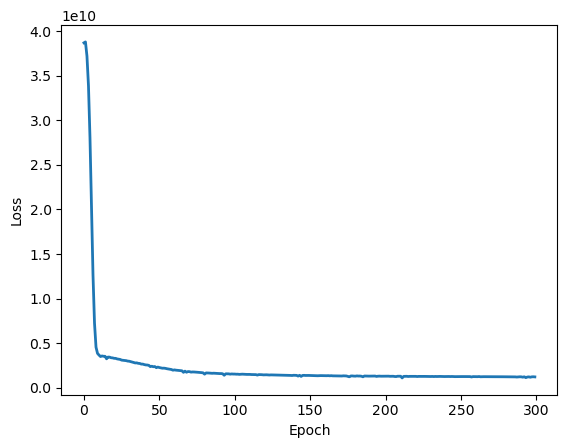

In [45]:
experiment = HousePricesExperiment(net_config, model, loss_method, optimizer)

losses, predictions, accuracy = experiment.train(scalled_train_df, y_train)

print(f'Training accuracy is {accuracy}')
plt.plot(losses.detach(), markerfacecolor='w', linewidth=2)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

### Network testing

In [46]:
targets_df = pd.DataFrame(y_test.tolist(), columns=[target_name])
test_tensor = torch.tensor(scalled_test_df.values).float()
targets_tensor = torch.tensor(targets_df.values).float()

predictions = model(test_tensor)

r2s_metric = R2Score()
r2s_metric.update(predictions, targets_tensor)
test_accuracy = r2s_metric.compute()

print(f'Testing accuracy is {test_accuracy}')

Testing accuracy is 0.8466469049453735


## XGBoost regression

### XGB model configuration

In [47]:
class XGBoostConfiguration:
    
    def __init__(self):
        self.max_depth = 5
        self.n_estimators = 1
        self.feature_selection_threshold=None

xgb_config = XGBoostConfiguration()
xgb_config.n_estimators = 50
xgb_config.max_depth = 5
xgb_config.feature_selection_threshold = 0.03

### XGBoost model creation

In [48]:
class XGBoostModelFactory:
    
    def create_regressor(self, config):
        xgb_model = xgb.XGBRegressor(max_depth=xgb_config.max_depth, n_estimators=xgb_config.n_estimators)
        return xgb_model

In [49]:
xgb_model_factory = XGBoostModelFactory()

### Feature Selection for XGBoost

In [50]:
xgb_model = xgb_model_factory.create_regressor(xgb_config)

xgb_selector = SelectFromModel(xgb_model, threshold=xgb_config.feature_selection_threshold)

xgb_selector.fit(scalled_train_df, y_train)
xgb_selected_features_index = scalled_train_df.columns[xgb_selector.get_support()]
xgb_selected_features = xgb_selected_features_index.values

xgb_selected_features


array(['GarageCars', 'KitchenAbvGr', 'GarageFinish', 'BsmtQual',
       'OverallQual'], dtype=object)

### XGBoost model training

In [51]:
xgb_model.fit(scalled_train_df, y_train)
xgb_predictions = xgb_model.predict(scalled_test_df)

In [52]:
#The XGB mean squered error
print('The XGB mean squered error is:')
mean_squared_error(y_test, xgb_predictions)

The XGB mean squered error is:


742640552.887747

In [53]:
#The XGB R2 score
print('The XGB R squered score is:')
r2_score(y_test, xgb_predictions)

The XGB R squered score is:


0.8705853038414699